In [14]:
import plotly.express as px
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import util
from sklearn.feature_extraction.text import TfidfVectorizer

### cluster relations based on 75% similarity and min size is 1

In [15]:
filename = 'vector_entity_relationships_relation.csv'
column = filename.split('_')[-1].split('.')[0]
vector_column = f'vector_{column}'
header = filename.split('_')[1]
(filename, header, column, vector_column)

('vector_entity_relationships_relation.csv',
 'entity',
 'relation',
 'vector_relation')

In [16]:
# Load the data and convert column var from strings to numpy arrays
df_relations = pd.read_csv(f'vectors/{filename}')
df_relations[vector_column] = df_relations[vector_column].apply(lambda x: np.array(json.loads(x)))

# Convert list of NumPy arrays to a single NumPy array to fix the warning
embeddings = np.array(df_relations[vector_column].tolist())

# Perform community detection clustering using SentenceTransformer's util
clusters = util.community_detection(embeddings, min_community_size=2, threshold=0.80)

# Apply PCA for dimensionality reduction (optional, for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)

# Create a DataFrame for Plotly
plot_data = []
for cluster_id in range(len(clusters)):
    cluster_points = X_pca[clusters[cluster_id]]
    plot_data.append(pd.DataFrame(cluster_points, columns=['PCA1', 'PCA2']).assign(cluster=cluster_id))

plot_df = pd.concat(plot_data)

# Generate the interactive plot
fig = px.scatter(plot_df, x='PCA1', y='PCA2', color='cluster',
                 title=f'Community Detection -{header} ({len(clusters)})',
                 color_continuous_scale=px.colors.sequential.Viridis, opacity=0.6, hover_name='cluster')
fig.show()

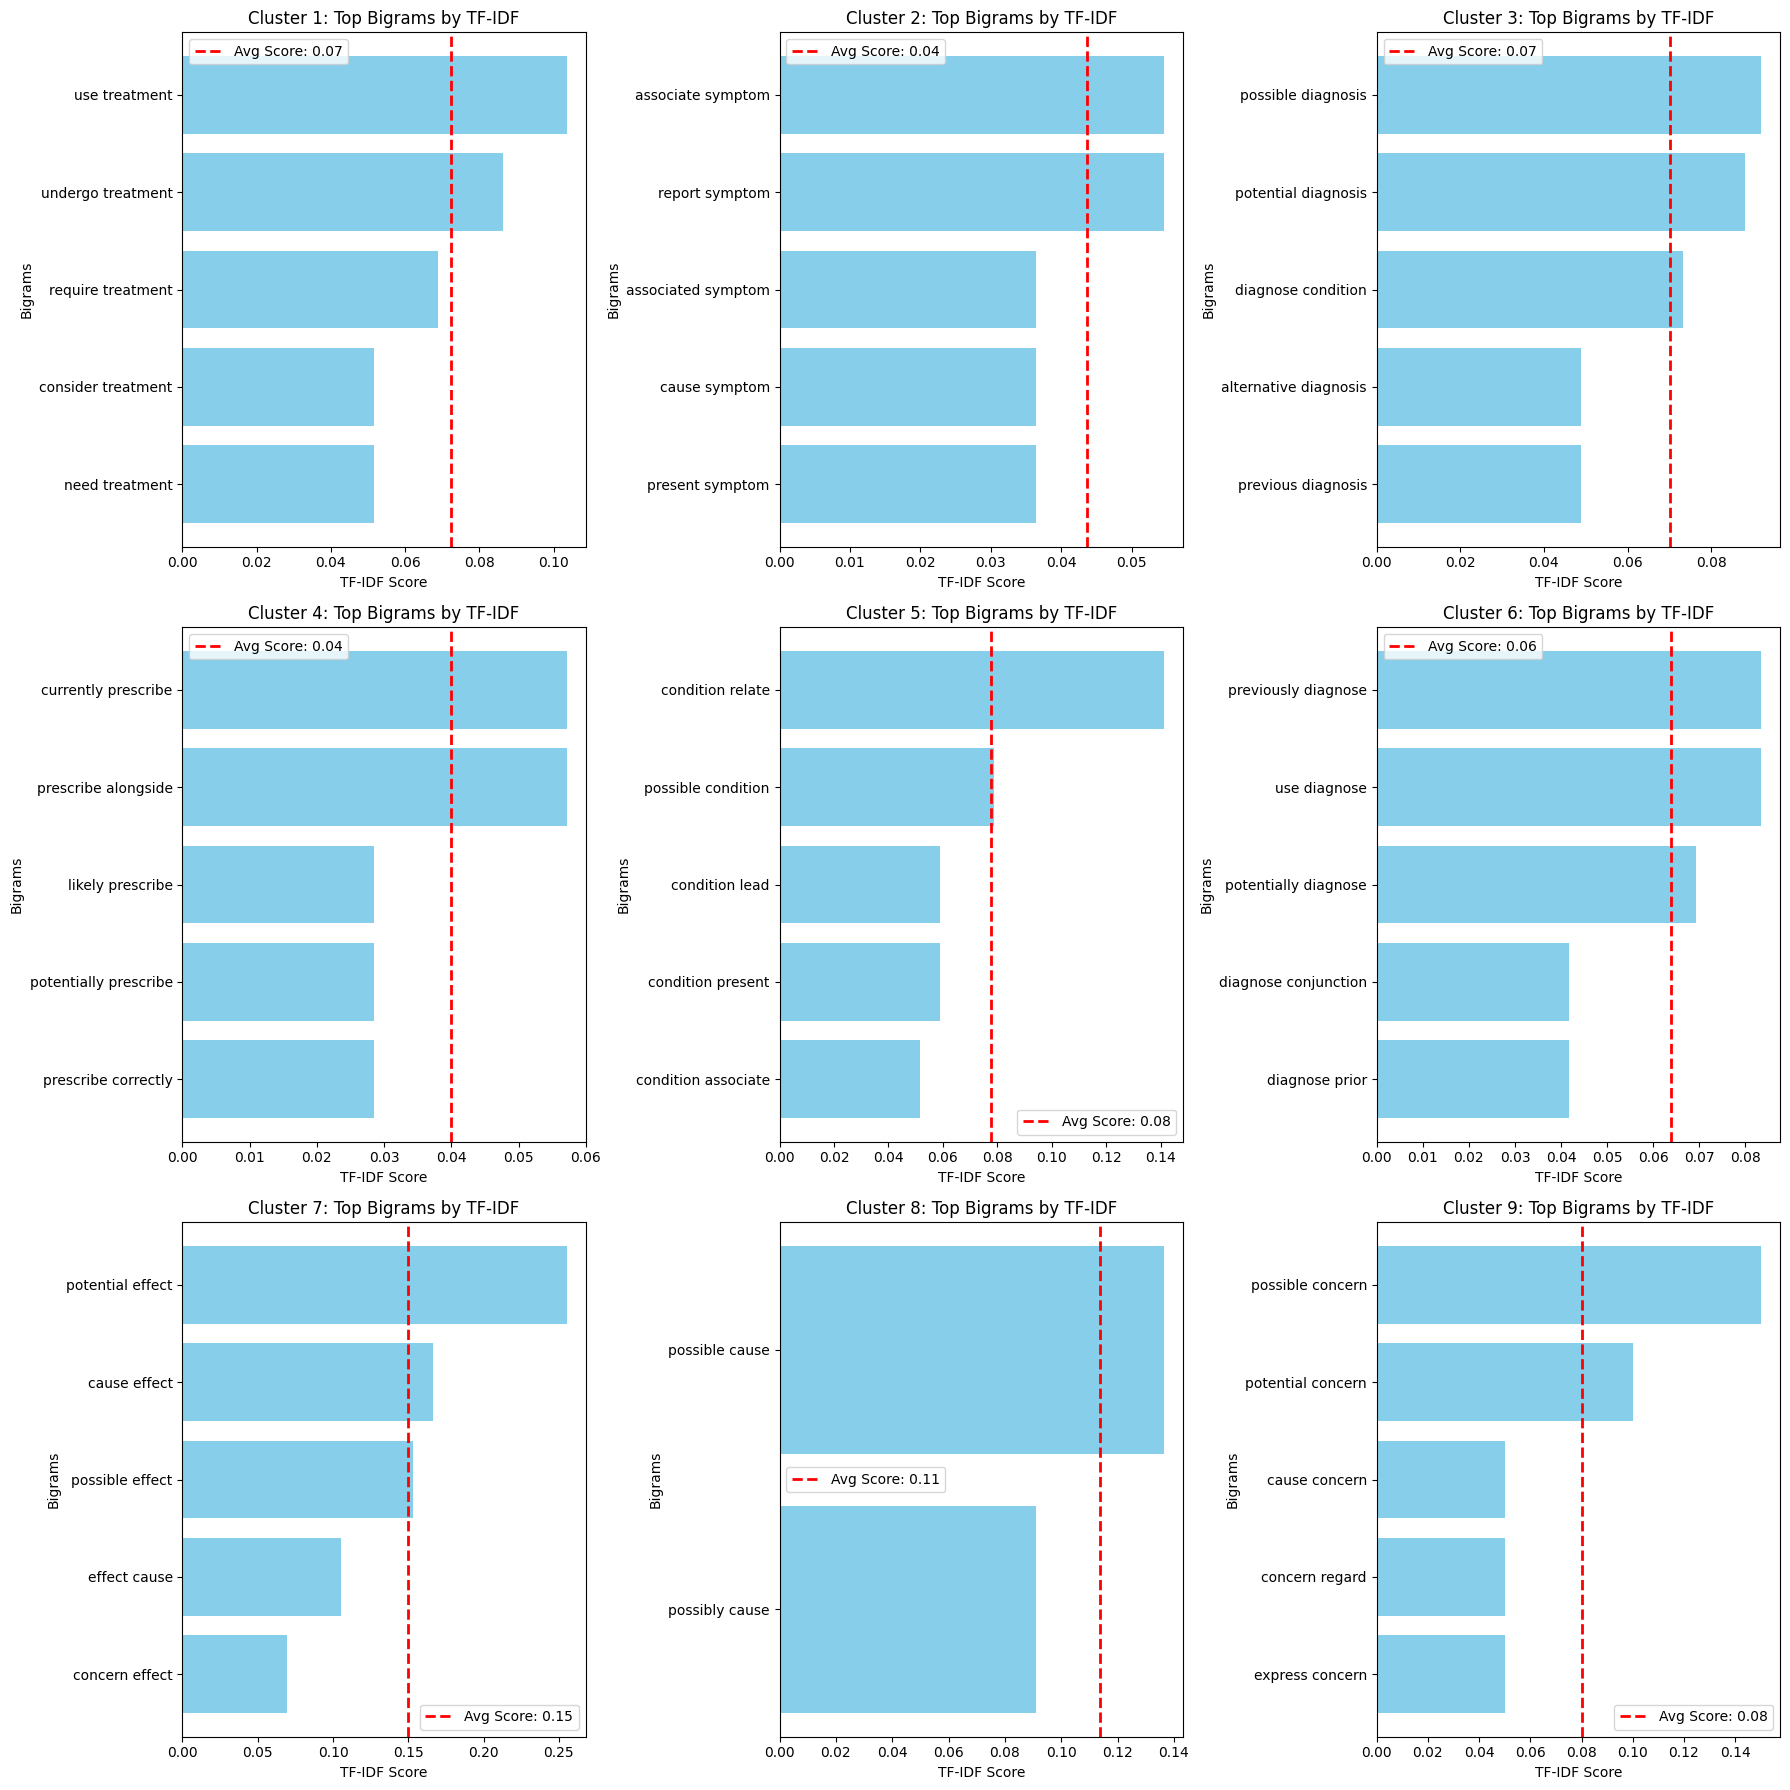

In [17]:
# Load the data and convert column from strings to numpy arrays
# df_relations = pd.read_csv(f'vectors/{filename}')
# df_relations[vector_column] = df_relations[vector_column].apply(eval).apply(np.array)

# Convert the list of NumPy arrays into a single NumPy array to address the warning
# embeddings = np.array(df_relations[vector_column].tolist())

# Perform community detection clustering using the SentenceTransformer's utility function
# clusters = util.community_detection(embeddings)

# Set up a grid for 9 subplots (3 rows by 3 columns) to visualize trending words
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

# Iterate over the first 9 clusters to analyze and visualize trending words
for cluster_id in range(min(9, len(clusters))):
    ax = axes[cluster_id]

    # Extract the text data for the current cluster
    cluster_texts = df_relations[column].iloc[clusters[cluster_id]].tolist()

    # Initialize TfidfVectorizer for bigrams (1,1)
    vectorizer = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)

    # Calculate the mean TF-IDF score for each bigram across all documents in the cluster
    tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)
    tfidf_scores_dict = dict(zip(vectorizer.get_feature_names_out(), tfidf_scores))

    # Get the top 20 bigrams with the highest TF-IDF scores
    most_common_bigrams = sorted(tfidf_scores_dict.items(), key=lambda x: x[1], reverse=True)

    # Separate bigrams and scores for plotting
    bigrams, scores = zip(*most_common_bigrams[:5])

    # Plot the most common bigrams as a bar chart
    ax.barh(bigrams, scores, color='skyblue')
    ax.set_title(f'Cluster {cluster_id + 1}: Top Bigrams by TF-IDF')
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('Bigrams')
    ax.invert_yaxis()  # Highest scores on top

    # Calculate and plot the average score as a red line
    avg_score = np.mean(scores)
    ax.axvline(avg_score, color='red', linestyle='--', linewidth=2, label=f'Avg Score: {avg_score:.2f}')
    ax.legend()

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the combined figure
plt.show()

# words

In [18]:

# df_relations = pd.read_csv(f'vectors/{filename}')
# df_relations[vector_column] = df_relations[vector_column].apply(eval).apply(np.array)
# 
# # Convert the list of NumPy arrays into a single NumPy array to address the warning
# embeddings = np.array(df_relations[vector_column].tolist())
# 
# # Perform community detection clustering using the SentenceTransformer's utility function
# clusters = util.community_detection(embeddings)

# Initialize lists to store data for the new CSV file
unique_ids = []
cluster_ids = []
cluster_names = []
relations = []
vector_relations = []

# Iterate over each cluster to analyze trending words
for cluster_id, cluster in enumerate(clusters):
    # Extract the text data for the current cluster
    cluster_texts = df_relations[column].iloc[cluster].tolist()

    # If there's only one sentence in the cluster, use it directly as the cluster name
    if len(cluster_texts) == 1:
        cluster_name = cluster_texts[0]
    else:
        # Initialize TfidfVectorizer for bigrams (2,2)
        try:
            vectorizer = TfidfVectorizer(ngram_range=(2, 3), stop_words='english')
            tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        except:
            try :
                vectorizer = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
                tfidf_matrix = vectorizer.fit_transform(cluster_texts)
            except:
                vectorizer = TfidfVectorizer(ngram_range=(1, 1))
                tfidf_matrix = vectorizer.fit_transform(cluster_texts)
            

        # Calculate the mean TF-IDF score for each bigram across all documents in the cluster
        tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)
        tfidf_scores_dict = dict(zip(vectorizer.get_feature_names_out(), tfidf_scores))

        # Get the top bigram with the highest TF-IDF score
        most_common_bigram = sorted(tfidf_scores_dict.items(), key=lambda x: x[1], reverse=True)[0][0]
        cluster_name = most_common_bigram

    # Store the data for each entry in the cluster
    for i in cluster:
        unique_ids.append(df_relations['unique_id'].iloc[i])
        cluster_ids.append(cluster_id + 1)  # Cluster IDs starting from 1
        cluster_names.append(cluster_name)
        relations.append(df_relations[column].iloc[i])
        vector_relations.append(df_relations[vector_column].iloc[i])

# Create a DataFrame with the new data
cluster_df = pd.DataFrame({
    'unique_id': unique_ids,
    'cluster_id': cluster_ids,
    'cluster_name': cluster_names,
    column: relations,
    # column: vector_relations
})

# Prepare the output directory and file name
output_dir = 'cluster'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f'cluster_{filename}')

# Save the DataFrame to a CSV file
cluster_df.to_csv(output_file, index=False)

print(f"Cluster file saved to {output_file}")

Cluster file saved to cluster/cluster_vector_entity_relationships_relation.csv
